In [1]:
#%%
from __future__ import print_function
import os, sys
from pprint import pprint
import json
import argparse
import numpy as np
import pickle
import librosa
from collections import Counter
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from submodlib.helper import create_kernel
from submodlib.functions.facilityLocationMutualInformation import (
    FacilityLocationMutualInformationFunction,
)
from submodlib.functions.facilityLocationVariantMutualInformation import (
    FacilityLocationVariantMutualInformationFunction,
)
from submodlib.functions.graphCutMutualInformation import (
    GraphCutMutualInformationFunction,
)
from submodlib.functions.logDeterminantMutualInformation import (
    LogDeterminantMutualInformationFunction,
)

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))


<ipython-input-1-e176ac5ab75d>:32: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#%%
def budget(budget_size):
    return int(4.92 * budget_size)


In [3]:
def plot_TSNE(
    X_ground,
    Y_ground,
    X_query,
    Y_query,
    selected_indices,
    dirs,
    query_set,
    query_set_percent,
    dest
):
    X = np.concatenate([X_ground, X_query], axis=0)
    Y = np.concatenate([np.array(Y_ground), np.array(Y_query)], axis=0)

    print(X.shape, Y.shape)
    print("\n\n")
    feat_cols = ["dim" + str(i) for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=feat_cols)
    df["Y"] = Y

    # label_map = dict(enumerate([x[:-8].split('_')[0]+'['+x[:-8].split('_')[1][0].upper()+']' for x in dirs]))
    label_map = dict(
        enumerate(
            [x[0].upper() + x[1] + ", " + x[:-8].split("_")[1][0].upper() for x in dirs]
        )
    )
    df["label"] = df["Y"].apply(lambda i: label_map[i])

    perp = 40
    iters = 1000
    tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=iters)
    tsne_results = tsne.fit_transform(df[feat_cols].values)

    df["tsne-2d-one"] = tsne_results[:, 0]
    df["tsne-2d-two"] = tsne_results[:, 1]

    fig = plt.figure(figsize=(6, 5))
    _ax = fig.add_subplot(1, 1, 1)
    # _ax.title.set_text('8 accents (1 speaker each) ground set: perplexity {}, iters {}'.format(perp, iters))
    palette = np.array(sns.color_palette("bright", 8))
    g = sns.scatterplot(
        x="tsne-2d-one",
        y="tsne-2d-two",
        hue="label",
        palette=sns.color_palette("hls", len(dirs)),
        #     palette=_color_map(dirs),
        #     palette="deep",
        data=df.iloc[list(range(len(X_ground)))],
        legend="full",
        #     markers= [0.5]*y.shape[0],
        #     legend=False,
        alpha=0.6,
        ax=_ax,
    )
    # g.legend(
    #          loc='upper right',
    # #          loc=1,
    #          bbox_to_anchor=(1.013, 1.017),
    # #          prop={'size':10}, markerscale=2,
    # #          labels=[x[0].upper()+x[1] for x in dirs]
    # )
    # fig.tight_layout()
    # fig.savefig('IndicTTS_t-SNE.svg') # , bbox_inches='tight', pad_inches=0
    # plt.savefig('IndicTTS_t-SNE.pgf', bbox_inches='tight', format='pgf', dpi=1200)
    # plt.show()
    # plt.close()

    g.legend(
        loc="lower right",
        bbox_to_anchor=(1.013, -0.02),
        prop={"size": 10},
        markerscale=1.5,
        #          labels=[x[0].upper()+x[1] for x in dirs]
    )

    query_indices = list(range(len(X_ground), len(X)))
    #     print(list(df.loc[selected_indices, "tsne-2d-one"]), list(df.loc[selected_indices, ["tsne-2d-two"]]))
    #     print(df.loc[selected_indices, "tsne-2d-one"].shape, df.loc[selected_indices, ["tsne-2d-two"]].shape)
    _ax.scatter(
        list(df.loc[selected_indices, "tsne-2d-one"]),
        list(df.loc[selected_indices, "tsne-2d-two"]),
        marker="*",
        color="darkblue",
    )
    _ax.scatter(
        list(df.loc[query_indices, "tsne-2d-one"]),
        list(df.loc[query_indices, "tsne-2d-two"]),
        marker="P",
        color="darkgreen",
    )
    plt.title(
        " ".join(
            [
                f"{accent}={round(percent, 3)}"
                for (accent, percent) in zip(query_set, query_set_percent)
            ]
        )
    )
    fig.tight_layout()

    fig.savefig(os.path.join(dest, "TSNE.png"), format="png")
    # plt.savefig(os.path.join(dest, "TSNE"), bbox_inches='tight', format='pgf', dpi=300)
    plt.savefig(os.path.join(dest, "TSNE.pdf"), format='pdf', dpi=300)
    plt.show()


In [4]:
#%%
def compute_subset(
    greedyList,
    config_dict,
):
    query_dir = config_dict["query_dir"]
    base_dir = config_dict["base_dir"]
    budget_size = config_dict["budget_size"]
    target_size = config_dict["target_size"]
    fxn = config_dict["fxn"]
    accent_feature_type = config_dict["accent_feature_type"]
    content_feature_type = config_dict["content_feature_type"]
    etaScale = config_dict["etaScale"]
    accent_similarity = config_dict["accent_similarity"]
    content_similarity = config_dict["content_similarity"]
    accent = config_dict["accent"]
    ground_list = config_dict["ground_list"]
    data_kernel_type = config_dict["data_kernel_type"]
    query_data_kernel_type = config_dict["query_data_kernel_type"]
    query_query_kernel_type = config_dict["query_query_kernel_type"]
    
    
    output_dir = os.path.join(
        base_dir,
        query_dir,
        "all",
        "mixed_query_set",
        "-".join([f"{accent}={round(fraction, 3)}" for accent, fraction in sorted(zip(config_dict["query_set"], config_dict["query_set_percent"]))]),
        f"budget_{budget_size}",
        f"target_{target_size}",
        f"{fxn}_etaScale_{round(etaScale, 5)}",
        f"accent_{accent_feature_type}",
        f"content_{content_feature_type}",
        f"kernel_g={data_kernel_type}_gq={query_data_kernel_type}_qq={query_query_kernel_type}",
        f"accent_{accent_similarity}",
        f"content_{content_similarity}",
    )
    os.makedirs(output_dir, exist_ok=True)

    all_indices = [j[0] for j in greedyList]
    all_gains = [j[1] for j in greedyList]

    # print("*******all_indices ******")
    # print(all_indices)

    # print("******all_gains*********")
    # print(all_gains)

    total_duration, index = 0, 0
    while total_duration + ground_list[all_indices[index]]["duration"] <= budget(
        budget_size
    ):
        total_duration += ground_list[all_indices[index]]["duration"]
        index += 1
    #         print(index, all_indices[index], len(ground_list))
    total_count = index
    selected_indices = all_indices[:index]
    plot_TSNE(
        config_dict["ground_accent_features"], 
        config_dict["ground_list_Y"], 
        config_dict["query_accent_features"], 
        config_dict["query_list_Y"], 
        selected_indices, config_dict["dirs"], 
        config_dict["query_set"], 
        config_dict["query_set_percent"], 
        dest=output_dir
    )
    selected_gains = all_gains[:index]
    # print("*******selected_indices ******")
    # print(selected_indices)

    # print("******selected_gains*********")
    # print(selected_gains)
    selected_list = [ground_list[j] for j in selected_indices]

    train_list = selected_list

    accent_sample_count, accent_sample_duration = 0, 0
    for item in selected_list:
        if item["audio_filepath"].split("/")[-4] == accent:
            accent_sample_count += 1
            accent_sample_duration += item["duration"]
    total_selections = Counter(
        [item["audio_filepath"].split("/")[-4] for item in selected_list]
    )

    with open(f"{output_dir}/train.json", "w") as f:
        for line in train_list:
            f.write("{}\n".format(json.dumps(line)))

    # plots(dirs, run_dir, ground_features, ground_features_Y, query_features, test_features, selected_indices, selected_gains, fxn)

    print("\n subset computed .... \n")
    stats = "total selections: " + str(total_count)
    stats += "\ntotal duration: " + str(total_duration)
    stats += "\naccented selections: " + str(accent_sample_count)
    stats += "\naccented duration: " + str(accent_sample_duration)
    stats += "\nall selections: " + str(total_selections)
    print(stats)
    with open(output_dir + "/stats.txt", "w") as f:
        f.write(stats)


In [5]:
#%%
def generate_greedyList(
    config_dict,
):
    fxn = config_dict["fxn"]
    ground_kernel = config_dict["ground_kernel"]
    query_kernel = config_dict["query_kernel"]
    query_query_kernel = config_dict["query_query_kernel"]
    etaScale = config_dict["etaScale"]
    budget_size = config_dict["budget_size"]
    print(f"\ncreating {fxn} object\n")
    if fxn == "FL1MI":
        obj1 = FacilityLocationMutualInformationFunction(
            n=len(ground_kernel),
            num_queries=query_kernel.shape[1],
            query_sijs=query_kernel,
            data_sijs=ground_kernel,
            magnificationEta=etaScale,
        )
    elif fxn == "LogDMI":
        obj1 = LogDeterminantMutualInformationFunction(
            n=len(ground_kernel),
            num_queries=query_kernel.shape[1],
            lambdaVal=1,  # should this also be tuned?
            query_sijs=query_kernel,
            data_sijs=ground_kernel,
            query_query_sijs=query_query_kernel,
            magnificationEta=etaScale,
        )
    elif fxn == "FL2MI":
        obj1 = FacilityLocationVariantMutualInformationFunction(
            n=len(ground_kernel),
            num_queries=query_kernel.shape[1],
            query_sijs=query_kernel,
            queryDiversityEta=etaScale,
        )
    elif fxn == "GCMI":
        obj1 = GraphCutMutualInformationFunction(
            n=len(ground_kernel),
            num_queries=query_kernel.shape[1],
            query_sijs=query_kernel,
        )
    else:
        print("\n\n\n............... ERROR not a valid FUNCTION, ............\n\n\n")
        return ValueError(f"{fxn} is not a valid Submod function for now")

    print(f"\n{fxn} object created\n")
    print("\ngenerating greedyList...\n")
    greedyList = obj1.maximize(
        budget=3 * budget_size,
        optimizer="LazyGreedy",
        stopIfZeroGain=False,
        stopIfNegativeGain=False,
        epsilon=0.1,
        verbose=False,
        show_progress=True,
    )
    print("\n.... greedyList generated ... \n")
    return greedyList


In [6]:
#%%
def load_features(accent, feature_type, filename):
    file_path = os.path.join(
        ".", accent, feature_type, f"{filename}_{feature_type}.file"
    )

    # print(
    #     f"Loading features for accent:= {accent}, feature_type:= {feature_type}, filename:= {filename} from path:= {file_path}"
    # )
    features = []
    with open(file_path, "rb") as f:
        while True:
            try:
                features.append(pickle.load(f))
            except EOFError:
                break
    #             if features[-1].shape[1]<39:
    #                 print(features[-1].shape)
    #                 print(file_dir, "bad feature file")
    #                 return np.array([[]])
    #                 sys.exit()
    features = np.concatenate(features, axis=0)
    # print(features.shape)
    return features


In [7]:
#%%
def select_features(accent_features, content_features, reqd_type):
    if reqd_type == "accent":
        return accent_features
    elif reqd_type == "content":
        return content_features
    else:
        return ValueError(
            f"""
            Reqd_type should be either `accent` or `content`. 
            But `{reqd_type}` is given.
            """
        )


In [8]:
#%%
def select_metric(accent_sim, content_sim, reqd_type):
    if reqd_type == "accent":
        return accent_sim
    elif reqd_type == "content":
        return content_sim
    else:
        return ValueError(
            f"""
            Reqd_type should be either `accent` or `content`. 
            But `{reqd_type}` is given.
            """
        )


In [9]:
#%%
def preprocess(config_dict):
    dirs = [
        "kannada_male_english",
        "malayalam_male_english",
        "rajasthani_male_english",
        "hindi_male_english",
        "tamil_male_english",
        "gujarati_female_english",
        "manipuri_female_english",
        "assamese_female_english",
    ]

    # print("**** Started Loading Seed features done *****")
    target_size = config_dict["target_size"]

    total_query_list = []
    total_query_accent_features = []
    total_query_content_features = []
    # print(config_dict["query_set"])
    for query_accent in config_dict["query_set"]:
        # print("query accent is ", query_accent)
        query_dir = f"{query_accent}/"

        # Query List and # Query Features
        query_file_path = os.path.join(
            config_dict["base_dir"],
            query_dir,
            f"seed{config_dict['json_file_suffix']}.json",
        )
        query_list = [json.loads(line.strip()) for line in open(query_file_path)]
        total_query_list.append(query_list)
        query_accent_features = load_features(
            accent=query_accent,
            feature_type=config_dict["accent_feature_type"],
            filename="seed",
        )
        total_query_accent_features.append(query_accent_features)
        query_content_features = load_features(
            accent=query_accent,
            feature_type=config_dict["content_feature_type"],
            filename="seed",
        )
        total_query_content_features.append(query_content_features)

        # print("Warning: not asserting the equality of query_list and its content features.")
        # print("Developer: Please add this check in the future..")
        assert len(query_list) == len(query_accent_features)
    #     print(len(total_query_list))
    #     print(total_query_list[0][:10])
    #     print("*****"* 10)
    #     print(total_query_list[1][:10])
    #     print([len(ls) for ls in total_query_list])
    query_list = []
    query_accent_features = []
    query_content_features = []
    query_list_Y = []
    for ind, query_accent in enumerate(config_dict["query_set"]):
        query_list.extend(
            total_query_list[ind][
                : int(
                    config_dict["target_size"] * config_dict["query_set_percent"][ind]
                )
            ]
        )
        query_list_Y.extend(
            [
                dirs.index(query_accent)
                for _ in range(
                    int(
                        config_dict["target_size"]
                        * config_dict["query_set_percent"][ind]
                    )
                )
            ]
        )
        query_accent_features.extend(
            total_query_accent_features[ind][
                : int(
                    config_dict["target_size"] * config_dict["query_set_percent"][ind]
                )
            ]
        )
        query_content_features.extend(
            total_query_content_features[ind][
                : int(
                    config_dict["target_size"] * config_dict["query_set_percent"][ind]
                )
            ]
        )
        # print("query_list_len == ", len(query_list))
    # print("query_list_len == ", len(query_list))
    query_accent_features = [_.reshape(1, -1) for _ in query_accent_features]
    query_content_features = [_.reshape(1, -1) for _ in query_content_features]

    query_accent_features = np.concatenate(query_accent_features, axis=0)
    query_content_features = np.concatenate(query_content_features, axis=0)
    # print(type(query_accent_features), type(query_content_features))

    query_list = query_list[:target_size]
    query_list_Y = query_list_Y[:target_size]
    query_accent_features = query_accent_features[:target_size]
    query_content_features = query_content_features[:target_size]
    # print(type(query_accent_features), type(query_content_features))

    # print("query_list is ", end = " ")
    # pprint(query_list)
    # print("Please verify that query_list distribution is as required")
    # print(query_accent_features[:4])
    # print(query_content_features[:4])
    # print("**** Loading Seed features done *****")

    # print("***** Start Loading Ground features ******")
    # Ground List and Ground Accent Features, Ground Content Features
    ground_list, ground_list_Y, ground_accent_features, ground_content_features = (
        [],
        [],
        [],
        [],
    )
    for i, _dir in enumerate(dirs):
        selection_file_path = os.path.join(
            config_dict["base_dir"],
            _dir,
            f"selection{config_dict['json_file_suffix']}.json",
        )

        # print(f"accent = {_dir}, selection_file_path is :=", selection_file_path)
        selection_file_list = [
            json.loads(line.strip()) for line in open(selection_file_path)
        ]
        ground_list.extend(selection_file_list)

        ground_accent_features.append(
            load_features(
                accent=_dir,
                feature_type=config_dict["accent_feature_type"],
                filename="selection",
            )
        )
        ground_content_features.append(
            load_features(
                accent=_dir,
                feature_type=config_dict["content_feature_type"],
                filename="selection",
            )
        )

        ground_list_Y.extend([i] * len(selection_file_list))

    ground_accent_features = np.concatenate(ground_accent_features, axis=0)
    # print("ground_list_length is := ", len(ground_list))
    # print("Warning: not asserting the equality of ground_list and its content features.")
    # print("Developer: Please add this check in the future..")
    assert len(ground_list) == len(ground_accent_features)
    ground_content_features = np.concatenate(ground_content_features, axis=0)

    # print("******* Loading Ground Features done ********")

    # ground_features_Y = np.asarray(ground_list_Y).reshape(-1, 1)

    ### test file
    ## We only need test_accent_features
    ## But for now we are loading both
    # test_file_path = os.path.join(config_dict['base_dir'], query_dir, "test.json")
    # test_list = [json.loads(line.strip()) for line in open(test_file_path)]
    # test_accent_features = load_features(test_file_path, config_dict['accent_feature_type'])
    # test_content_features = load_features(test_file_path, config_dict['content_feature_type'])

    # print(
    #     f"Ground stats",
    #     f"Length = {len(ground_list)}",
    #     f"Accent features shape = {ground_accent_features.shape}",
    #     f"Content features shape = {ground_content_features.shape}",
    #     sep="\n",
    # )
    # print("\n\n")
    # print(
    #     f"Query stats",
    #     f"Length = {len(query_list)}",
    #     f"Accent features shape = {query_accent_features.shape}",
    #     f"Content features shape = {query_content_features.shape}",
    #     sep="\n",
    # )
    # print(
    #     f"Test stats",
    #     f"Length = {len(test_list)}",
    #     f"Accent features shape = {test_accent_features.shape}",
    # )
    # print(len(query_list), query_features.shape)
    # print(len(test_list), test_features.shape)

    # print("creating kernels ....")
    t1 = time.time()
    # print(f"content_similarity is {config_dict['content_similarity']}")
    ground_kernel = create_kernel(
        select_features(
            accent_features=ground_accent_features,
            content_features=ground_content_features,
            reqd_type=config_dict["data_kernel_type"],
        ),
        metric=select_metric(
            accent_sim=config_dict["accent_similarity"],
            content_sim=config_dict["content_similarity"],
            reqd_type=config_dict["data_kernel_type"],
        ),
        mode="dense",
    )
    query_kernel = create_kernel(
        select_features(
            accent_features=query_accent_features,
            content_features=query_content_features,
            reqd_type=config_dict["query_data_kernel_type"],
        ),
        # query_accent_features,
        metric=select_metric(
            accent_sim=config_dict["accent_similarity"],
            content_sim=config_dict["content_similarity"],
            reqd_type=config_dict["query_data_kernel_type"],
        ),
        mode="dense",
        X_rep=select_features(
            accent_features=ground_accent_features,
            content_features=ground_content_features,
            reqd_type=config_dict["query_data_kernel_type"],
        ),
    )
    query_query_kernel = create_kernel(
        select_features(
            accent_features=query_accent_features,
            content_features=query_content_features,
            reqd_type=config_dict["query_query_kernel_type"],
        ),
        metric=select_metric(
            accent_sim=config_dict["accent_similarity"],
            content_sim=config_dict["content_similarity"],
            reqd_type=config_dict["query_query_kernel_type"],
        ),
        mode="dense",
    )

    ground_kernel = (1 + ground_kernel) / 2
    query_kernel = (1 + query_kernel) / 2
    query_query_kernel = (1 + query_query_kernel) / 2

    # print("************ ground kernel*************")
    # print(ground_kernel)
    # print("************ query kernel*************")
    # print(query_kernel)
    # print("************ query query kernel*************")
    # print(query_query_kernel, flush=True)

    t2 = time.time()
    # print("kernel creation done ....", t2 - t1)

    # print("ground_kernel: ", ground_kernel.shape)
    # print("query_kernel: ", query_kernel.shape)
    # print("query_query_kernel: ", query_query_kernel.shape)
    return {
        "ground_kernel": ground_kernel,
        "query_kernel": query_kernel,
        "query_query_kernel": query_query_kernel,
        "query_dir": config_dict["accent"],
        "ground_list": ground_list,
        "ground_list_Y": ground_list_Y,
        "ground_accent_features": ground_accent_features,
        "dirs": dirs,
        "query_accent_features": query_accent_features,
        "query_list_Y": query_list_Y,
    }


In [10]:
#%%
def do_expt(**kwargs):

    args = kwargs
    # pprint(args)

    config_dict = {}
    config_dict["base_dir"] = ""
    config_dict["budget_size"] = args["budget"]
    config_dict["target_size"] = args["target"]
    config_dict["etaScale"] = args["eta_scale"]
    config_dict["accent_similarity"] = args["accent_similarity"]
    config_dict["content_similarity"] = args["content_similarity"]
    config_dict["fxn"] = args["fxn"]
    config_dict["accent"] = args["accent"]
    config_dict["accent_feature_type"] = args["accent_feature_type"]
    config_dict["content_feature_type"] = args["content_feature_type"]
    config_dict["data_kernel_type"] = kwargs["data_kernel_type"]
    config_dict["query_data_kernel_type"] = kwargs["query_data_kernel_type"]
    config_dict["query_query_kernel_type"] = kwargs["query_query_kernel_type"]
    config_dict["query_set"] = kwargs["query_set"]
    config_dict["query_set_percent"] = kwargs["query_set_percent"]

    config_dict["json_file_suffix"] = ""
    if (
        config_dict["accent_feature_type"].find("_") != -1
        and config_dict["accent_feature_type"].find("rep") != -1
    ):
        config_dict["json_file_suffix"] = (
            "_" + config_dict["accent_feature_type"].split("_")[-1]
        )

    print("\n\n\t\t***** Printing Experiment configuration settings ******\n\n")
    pprint(config_dict)
    print("\n\n\t\t***** End of Experiment configuration settings ******\n\n")
    config_dict.update(preprocess(config_dict))

    greedyList = generate_greedyList(
        config_dict,
    )
    compute_subset(
        greedyList,
        config_dict,
    )




		***** Printing Experiment configuration settings ******


{'accent': 'manipuri_female_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'GCMI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['manipuri_female_english', 'rajasthani_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating GCMI object


GCMI object created


generating greedyList...


.... greedyList generated ... 

(34566, 39) (34566,)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 34566 samples in 0.001s...


/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 36.429s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

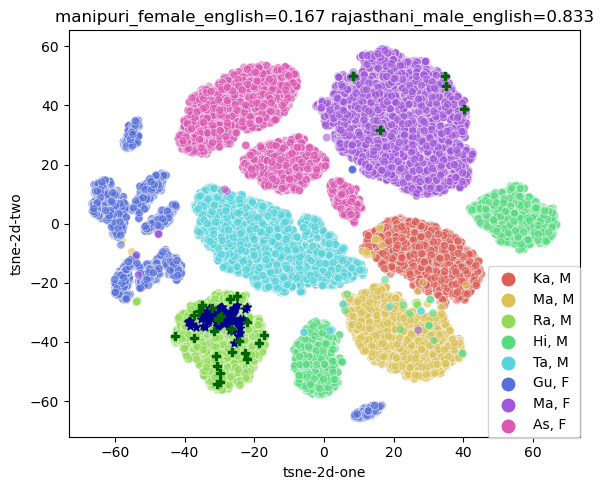


 subset computed .... 

total selections: 117
total duration: 736.52015
accented selections: 0
accented duration: 0
all selections: Counter({'rajasthani_male_english': 117})


		***** Printing Experiment configuration settings ******


{'accent': 'manipuri_female_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'FL2MI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['manipuri_female_english', 'rajasthani_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating FL2MI object


FL2MI object created


generating greedyList...


.... greedyList generated ... 

(34566, 39) (34566,)





/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 34566 samples in 0.002s...
[t-SNE] Computed neighbors for 34566 samples in 55.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for s

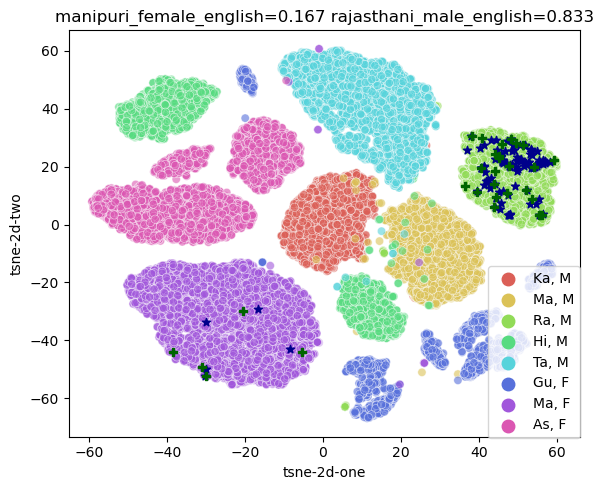


 subset computed .... 

total selections: 112
total duration: 736.3000639999998
accented selections: 5
accented duration: 16.899896
all selections: Counter({'rajasthani_male_english': 107, 'manipuri_female_english': 5})


		***** Printing Experiment configuration settings ******


{'accent': 'manipuri_female_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'FL1MI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['manipuri_female_english', 'rajasthani_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating FL1MI object


FL1MI object created


generating greedyList...


.... greedyList generated ... 

(34566, 39) (3456

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 32.564s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

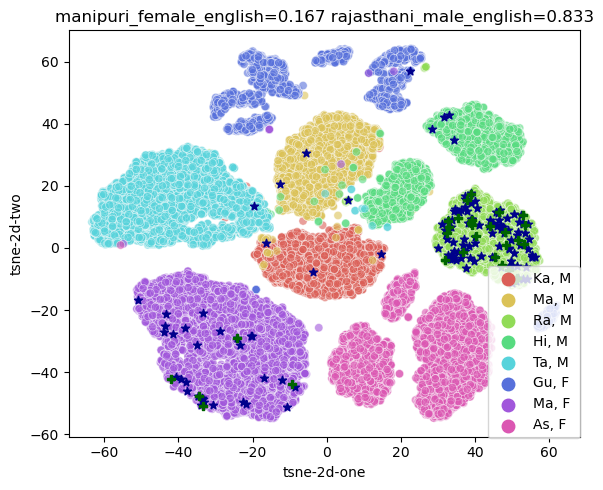


 subset computed .... 

total selections: 140
total duration: 737.9016489999997
accented selections: 29
accented duration: 105.38318799999996
all selections: Counter({'rajasthani_male_english': 100, 'manipuri_female_english': 29, 'hindi_male_english': 4, 'kannada_male_english': 3, 'malayalam_male_english': 2, 'gujarati_female_english': 1, 'tamil_male_english': 1})


		***** Printing Experiment configuration settings ******


{'accent': 'manipuri_female_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'LogDMI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['manipuri_female_english', 'rajasthani_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configur

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 37.373s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

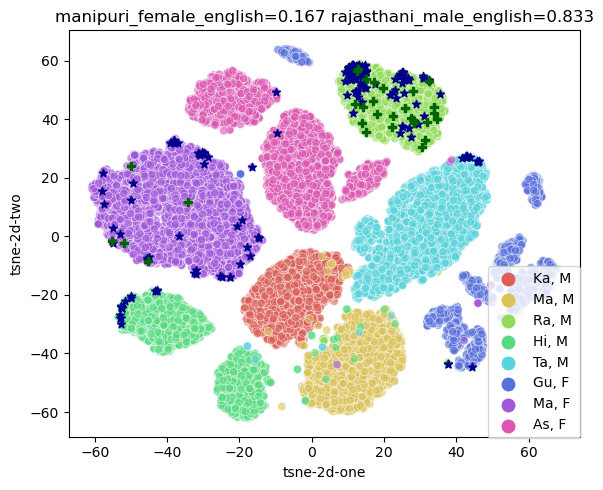


 subset computed .... 

total selections: 176
total duration: 737.2520459999997
accented selections: 42
accented duration: 95.00947899999997
all selections: Counter({'rajasthani_male_english': 105, 'manipuri_female_english': 42, 'hindi_male_english': 14, 'tamil_male_english': 12, 'assamese_female_english': 2, 'gujarati_female_english': 1})


		***** Printing Experiment configuration settings ******


{'accent': 'rajasthani_male_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'GCMI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['manipuri_female_english', 'rajasthani_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



cr

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 34.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

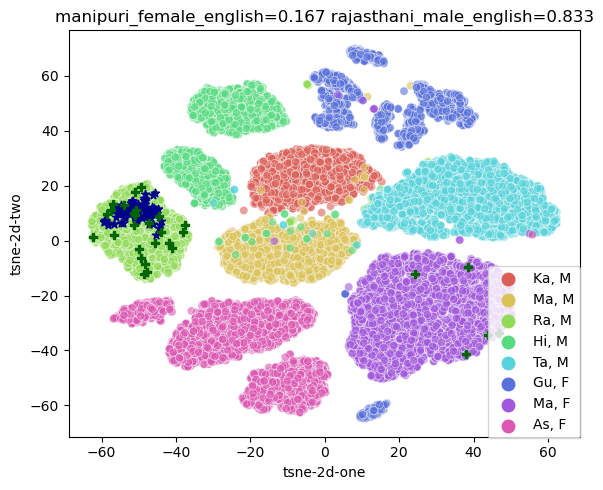


 subset computed .... 

total selections: 117
total duration: 736.52015
accented selections: 117
accented duration: 736.52015
all selections: Counter({'rajasthani_male_english': 117})


		***** Printing Experiment configuration settings ******


{'accent': 'rajasthani_male_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'FL2MI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['manipuri_female_english', 'rajasthani_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating FL2MI object


FL2MI object created


generating greedyList...


.... greedyList generated ... 

(34566, 39) (34566,)



[t-SNE] Computing 121 nearest

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 33.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

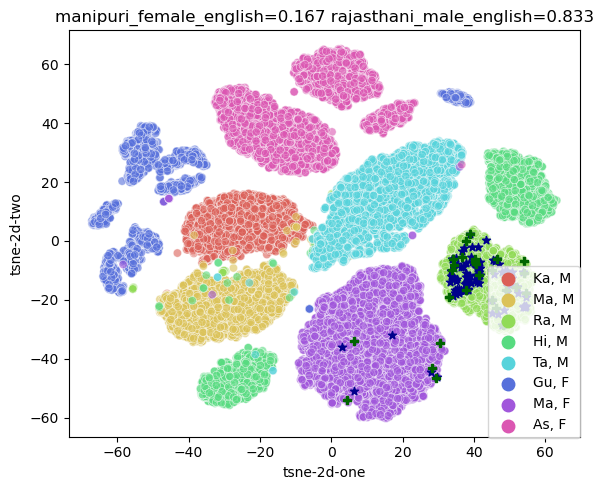


 subset computed .... 

total selections: 112
total duration: 736.3000639999998
accented selections: 107
accented duration: 719.4001679999997
all selections: Counter({'rajasthani_male_english': 107, 'manipuri_female_english': 5})


		***** Printing Experiment configuration settings ******


{'accent': 'rajasthani_male_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'FL1MI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['manipuri_female_english', 'rajasthani_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating FL1MI object


FL1MI object created


generating greedyList...


.... greedyList generated ... 

(34566,

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 31.306s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

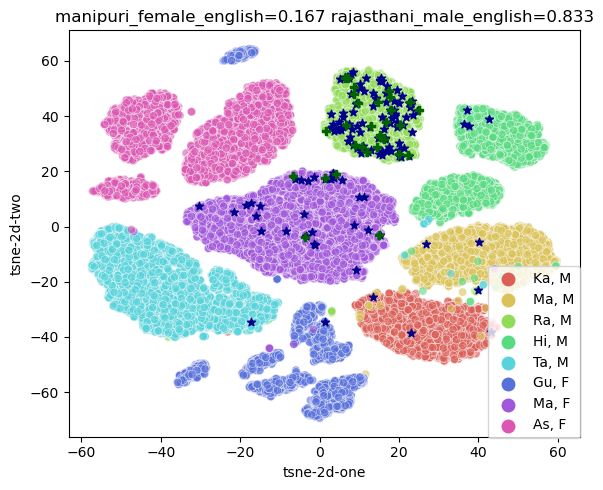


 subset computed .... 

total selections: 140
total duration: 737.9016489999997
accented selections: 100
accented duration: 576.9423979999999
all selections: Counter({'rajasthani_male_english': 100, 'manipuri_female_english': 29, 'hindi_male_english': 4, 'kannada_male_english': 3, 'malayalam_male_english': 2, 'gujarati_female_english': 1, 'tamil_male_english': 1})


		***** Printing Experiment configuration settings ******


{'accent': 'rajasthani_male_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'LogDMI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['manipuri_female_english', 'rajasthani_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configur

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 40.809s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

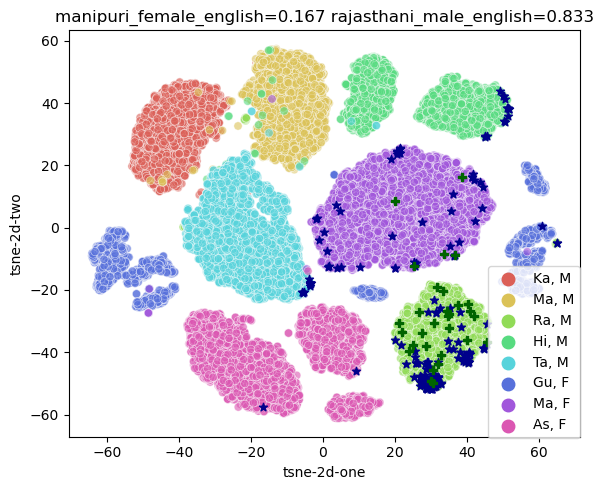


 subset computed .... 

total selections: 176
total duration: 737.2520459999997
accented selections: 105
accented duration: 530.8460629999997
all selections: Counter({'rajasthani_male_english': 105, 'manipuri_female_english': 42, 'hindi_male_english': 14, 'tamil_male_english': 12, 'assamese_female_english': 2, 'gujarati_female_english': 1})


		***** Printing Experiment configuration settings ******


{'accent': 'assamese_female_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'GCMI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['assamese_female_english', 'kannada_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



crea

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 36.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

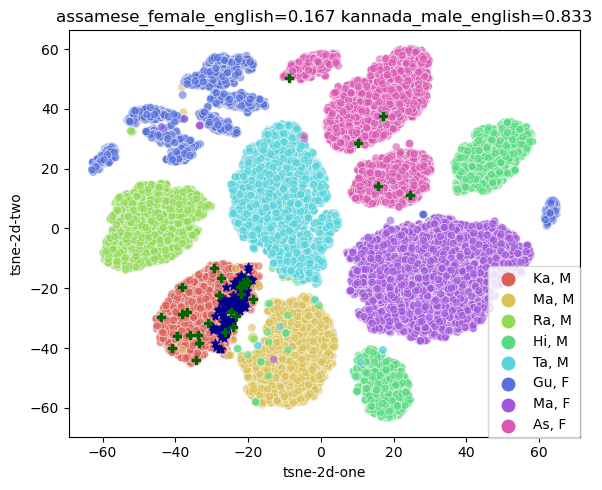


 subset computed .... 

total selections: 159
total duration: 735.3483340000001
accented selections: 0
accented duration: 0
all selections: Counter({'kannada_male_english': 159})


		***** Printing Experiment configuration settings ******


{'accent': 'assamese_female_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'FL2MI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['assamese_female_english', 'kannada_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating FL2MI object


FL2MI object created


generating greedyList...


.... greedyList generated ... 

(34566, 39) (34566,)



[t-SNE] Computing 121 nearest neighbo

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 33.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

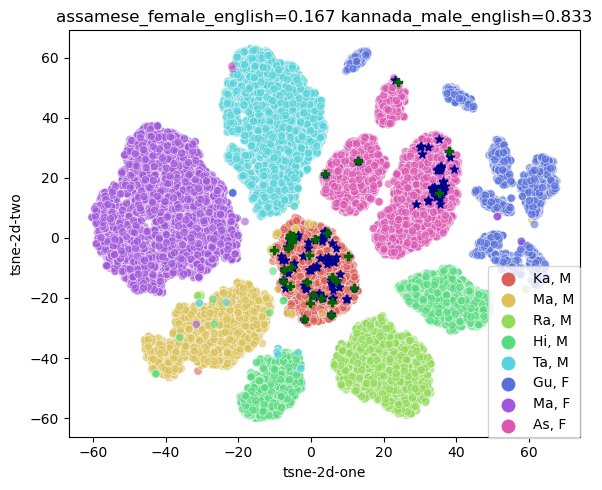


 subset computed .... 

total selections: 118
total duration: 731.4912690000001
accented selections: 46
accented duration: 286.80020699999994
all selections: Counter({'kannada_male_english': 72, 'assamese_female_english': 46})


		***** Printing Experiment configuration settings ******


{'accent': 'assamese_female_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'FL1MI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['assamese_female_english', 'kannada_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating FL1MI object


FL1MI object created


generating greedyList...


.... greedyList generated ... 

(34566, 39) (

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 35.609s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

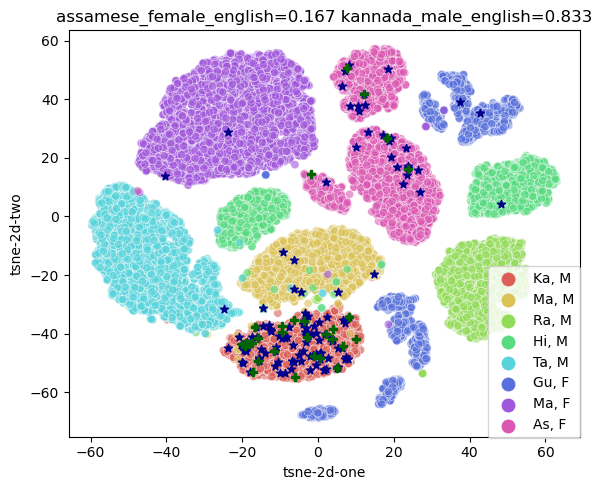


 subset computed .... 

total selections: 125
total duration: 735.5927539999998
accented selections: 25
accented duration: 137.038708
all selections: Counter({'kannada_male_english': 87, 'assamese_female_english': 25, 'malayalam_male_english': 7, 'gujarati_female_english': 2, 'manipuri_female_english': 2, 'hindi_male_english': 2})


		***** Printing Experiment configuration settings ******


{'accent': 'assamese_female_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'LogDMI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['assamese_female_english', 'kannada_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating Log

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 35.025s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

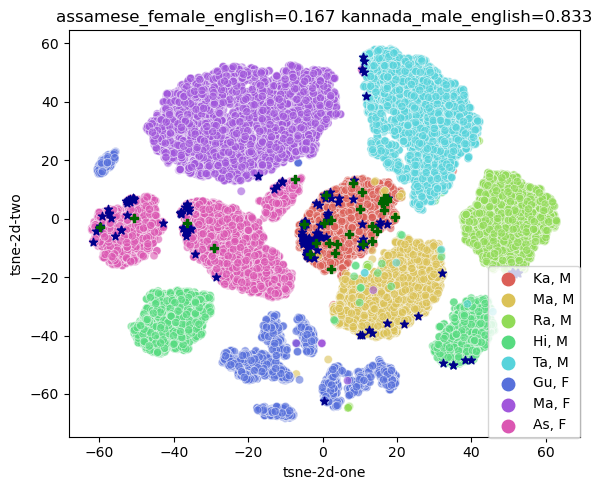


 subset computed .... 

total selections: 153
total duration: 734.9922910000005
accented selections: 52
accented duration: 201.07248100000007
all selections: Counter({'kannada_male_english': 75, 'assamese_female_english': 52, 'malayalam_male_english': 8, 'rajasthani_male_english': 7, 'hindi_male_english': 5, 'tamil_male_english': 4, 'manipuri_female_english': 1, 'gujarati_female_english': 1})


		***** Printing Experiment configuration settings ******


{'accent': 'kannada_male_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'GCMI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['assamese_female_english', 'kannada_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End o

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 35.989s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

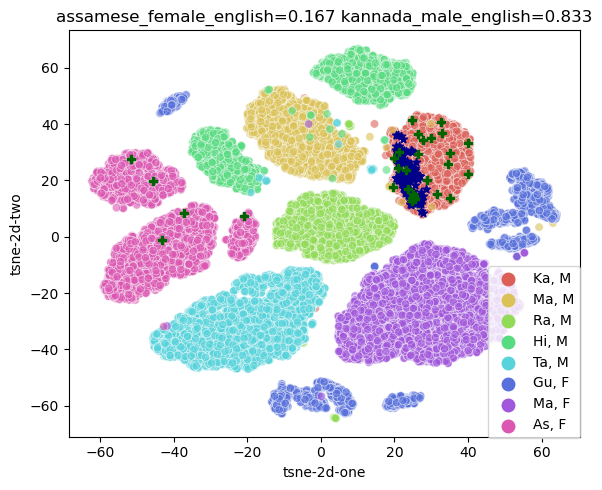


 subset computed .... 

total selections: 159
total duration: 735.3483340000001
accented selections: 159
accented duration: 735.3483340000001
all selections: Counter({'kannada_male_english': 159})


		***** Printing Experiment configuration settings ******


{'accent': 'kannada_male_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'FL2MI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['assamese_female_english', 'kannada_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating FL2MI object


FL2MI object created


generating greedyList...


.... greedyList generated ... 

(34566, 39) (34566,)





/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 34566 samples in 0.002s...
[t-SNE] Computed neighbors for 34566 samples in 36.698s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for s

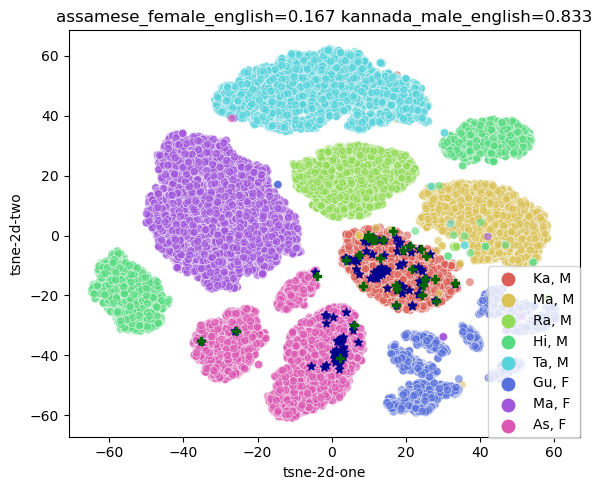


 subset computed .... 

total selections: 118
total duration: 731.4912690000001
accented selections: 72
accented duration: 444.691062
all selections: Counter({'kannada_male_english': 72, 'assamese_female_english': 46})


		***** Printing Experiment configuration settings ******


{'accent': 'kannada_male_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'FL1MI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['assamese_female_english', 'kannada_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating FL1MI object


FL1MI object created


generating greedyList...


.... greedyList generated ... 

(34566, 39) (34566,)





/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 32.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

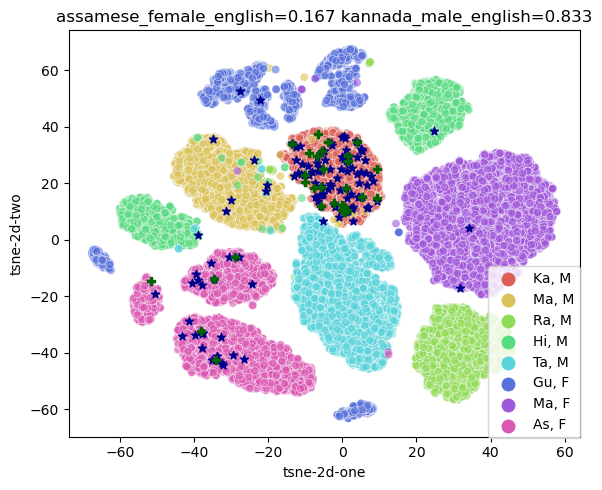


 subset computed .... 

total selections: 125
total duration: 735.5927539999998
accented selections: 87
accented duration: 534.2805050000001
all selections: Counter({'kannada_male_english': 87, 'assamese_female_english': 25, 'malayalam_male_english': 7, 'gujarati_female_english': 2, 'manipuri_female_english': 2, 'hindi_male_english': 2})


		***** Printing Experiment configuration settings ******


{'accent': 'kannada_male_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'LogDMI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['assamese_female_english', 'kannada_male_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** End of Experiment configuration settings ******



creating

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 38.884s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

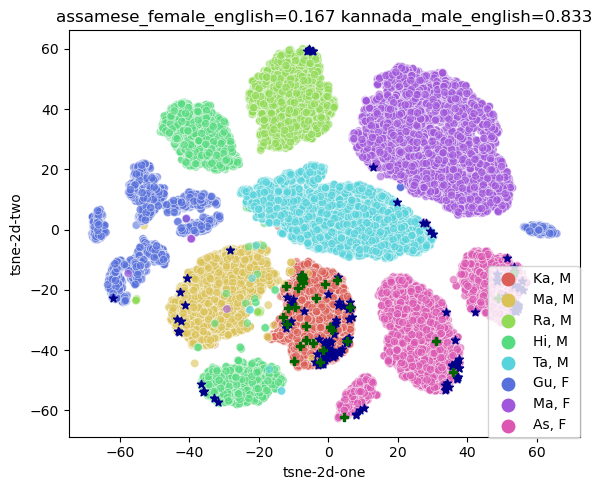


 subset computed .... 

total selections: 153
total duration: 734.9922910000005
accented selections: 75
accented duration: 427.64695900000004
all selections: Counter({'kannada_male_english': 75, 'assamese_female_english': 52, 'malayalam_male_english': 8, 'rajasthani_male_english': 7, 'hindi_male_english': 5, 'tamil_male_english': 4, 'manipuri_female_english': 1, 'gujarati_female_english': 1})


		***** Printing Experiment configuration settings ******


{'accent': 'malayalam_male_english',
 'accent_feature_type': '39',
 'accent_similarity': 'cosine',
 'base_dir': '',
 'budget_size': 150,
 'content_feature_type': 'tf_idf_2gram',
 'content_similarity': 'cosine',
 'data_kernel_type': 'accent',
 'etaScale': 1.0,
 'fxn': 'GCMI',
 'json_file_suffix': '',
 'query_data_kernel_type': 'accent',
 'query_query_kernel_type': 'accent',
 'query_set': ['malayalam_male_english', 'gujarati_female_english'],
 'query_set_percent': [0.16666666666666666, 0.8333333333333334],
 'target_size': 30}


		***** E

/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mayank/.conda/envs/error/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 34566 samples in 32.701s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34566
[t-SNE] Computed conditional probabilities for sample 2000 / 34566
[t-SNE] Computed conditional probabilities for sample 3000 / 34566
[t-SNE] Computed conditional probabilities for sample 4000 / 34566
[t-SNE] Computed conditional probabilities for sample 5000 / 34566
[t-SNE] Computed conditional probabilities for sample 6000 / 34566
[t-SNE] Computed conditional probabilities for sample 7000 / 34566
[t-SNE] Computed conditional probabilities for sample 8000 / 34566
[t-SNE] Computed conditional probabilities for sample 9000 / 34566
[t-SNE] Computed conditional probabilities for sample 10000 / 34566
[t-SNE] Computed conditional probabilities for sample 11000 / 34566
[t-SNE] Computed conditional probabilities for sample 12000 / 34566
[t-SNE] Computed conditional probabilities for sample 13000 / 34566
[t-SNE] Computed conditional probabilities for sample 14000 / 3456

KeyboardInterrupt: 

In [11]:
#%%
import itertools


if __name__ == "__main__":
    # parser = argparse.ArgumentParser(description="TSS input")
    # parser.add_argument(
    #     "--budget", type=int, help="budget", required=True, choices=[150]
    # )
    # parser.add_argument(
    #     "--target", type=int, help="target", required=True, choices=[20]
    # )
    # parser.add_argument("--eta_scale", type=float, help="eta value", required=True)
    # parser.add_argument(
    #     "--accent_similarity",
    #     type=str,
    #     help="accent_similarity metric",
    #     choices=["euclidean", "cosine"],
    #     required=True,
    # )
    # parser.add_argument(
    #     "--content_similarity",
    #     type=str,
    #     help="content_similarity_metric",
    #     choices=["euclidean", "cosine"],
    #     required=True,
    # )
    # parser.add_argument(
    #     "--fxn",
    #     type=str,
    #     help="function",
    #     choices=["FL1MI", "FL2MI", "GCMI", "LogDMI"],
    #     required=True,
    # )
    # parser.add_argument(
    #     "--accent",
    #     type=str,
    #     help="query set",
    #     required=True,
    #     choices=[
    #         "assamese_female_english",
    #         "gujarati_female_english",
    #         "manipuri_female_english",
    #         "hindi_male_english",
    #         "kannada_male_english",
    #         "malayalam_male_english",
    #         "tamil_male_english",
    #         "rajasthani_male_english",
    #     ],
    # )
    # parser.add_argument(
    #     "--accent_feature_type",
    #     type=str,
    #     help="which accent feature space",
    #     required=True,
    #     choices=["39", "39_norm", "39_10rep", "39_3rep", "39_2rep", "39_1rep"],
    # )
    # parser.add_argument(
    #     "--content_feature_type",
    #     type=str,
    #     help="which content diversity feature space",
    #     required=True,
    #     choices=["tf_idf_2gram"],  # 10rep of tf_idf is not supported yet
    # )

    # parser.add_argument(
    #     "--data_kernel_type",
    #     required=True,
    #     type=str,
    #     choices=["accent", "content"],
    #     help="ground ground kernel type",
    # )
    # parser.add_argument(
    #     "--query_data_kernel_type",
    #     required=True,
    #     type=str,
    #     choices=["accent", "content"],
    #     help="query ground kernel type",
    # )
    # parser.add_argument(
    #     "--query_query_kernel_type",
    #     required=True,
    #     type=str,
    #     choices=["accent", "content"],
    #     help="query query kernel type",
    # )

    # args = parser.parse_args()
    # do_expt(**vars(args))

    dirs = [
        (["assamese_female_english", "hindi_male_english"], [1/2, 1/2]),
        (["rajasthani_male_english", "tamil_male_english"], [1/2, 1/2]),
        # (["manipuri_female_english", "rajasthani_male_english"], [1/6, 5/6]),
        # (["assamese_female_english", "kannada_male_english"] , [1/6, 5/6]),
        # (["malayalam_male_english", "gujarati_female_english"], [1/6, 5/6]),
        # (["assamese_female_english", "kannada_male_english", "tamil_female_english"], [2/10, 3/10, 5/10]),
    ]

    budget = 750
    target = 50

    # for query_set in itertools.combinations(dirs, 2):
    for query_set, query_set_percent in dirs:
        for accent in query_set:
            remaining_accents = [_ for _ in query_set if _ != accent]
            # for fxn in ["GCMI", "LogDMI", "FL1MI", "FL2MI"]:
            for fxn in ["GCMI", "FL2MI", "FL1MI", "LogDMI"]:
                # for query_set_percent in [(0.1*x, 1 - 0.1*x) for x in range(11)]:
                # for query_set_percent in [(0.1 * x, 1 - 0.1 * x) for x in range(11)]:
                    # print(query_set_percent)
                    param_dict = {
                        "budget": budget,
                        # "target": 20,
                        "target": target,
                        "eta_scale": 1.0,
                        "accent_similarity": "cosine",
                        "content_similarity": "cosine",
                        "fxn": fxn,
                        "accent": accent,
                        "accent_feature_type": "39",
                        "content_feature_type": "tf_idf_2gram",
                        "data_kernel_type": "accent",
                        "query_data_kernel_type": "accent",
                        "query_query_kernel_type": "accent",
                        "query_set": query_set,
                        "query_set_percent": query_set_percent,
                    }
                    do_expt(**param_dict)


In [ ]:
import pandas as pd

dat = pd.DataFrame({"a": [1, 2, 3], "b": [1, 4, 9], "c": [1, 25, 125]})
dat


a  b    c
0  1  1    1
1  2  4   25
2  3  9  125

In [ ]:
print(list(dat.loc[[1, 2], ["a"]]))
dat.loc[[1, 2], ["a"]]
print(type(dat.loc[[1, 2], ["a"]]))


['a']
<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(list(dat.loc[[1, 2], "a"]))
dat.loc[[1, 2], "a"]
print(type(dat.loc[[1, 2], "a"]))


[2, 3]
<class 'pandas.core.series.Series'>
